## Setup

In [101]:
# # check GPU
!nvidia-smi

Fri Jan 13 17:44:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |   1386MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [102]:
# # pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
!cd mode_connectivity; git checkout super_model

fatal: destination path 'mode_connectivity' already exists and is not an empty directory.
M	geodesic_opt.py
Already on 'super_model'
Your branch is up to date with 'origin/super_model'.


In [103]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [105]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

# Training MLP models

In [106]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 10
training_config.seed = 7

# train model a
# model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_a = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# change seed to get different model
training_config.seed = 42

# train model b
# model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_b = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0942, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0708, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0864, Accuracy: (97%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0811, Accuracy: (97%)
Train Epoch: 6, Train Accuracy: (99%) 
Average loss: 0.0794, Accuracy: (98%)
Train Epoch: 7, Train Accuracy: (99%) 
Average loss: 0.0721, Accuracy: (98%)
Train Epoch: 8, Train Accuracy: (99%) 
Average loss: 0.0732, Accuracy: (98%)
Train Epoch: 9, Train Accuracy: (99%) 
Average loss: 0.0811, Accuracy: (98%)
Train Epoch: 10, Train Accuracy: (99%) 
Average loss: 0.0778, Accuracy: (98%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1392, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0911, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0784, Accuracy: (98%

# LMC in param space

In [111]:
n_points = 10
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
)
torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 


performing naive interpolation
Average loss: 0.0121, Accuracy: (100%)
Average loss: 0.0778, Accuracy: (98%)
Average loss: 0.0247, Accuracy: (99%)
Average loss: 0.0675, Accuracy: (98%)
Average loss: 0.1182, Accuracy: (99%)
Average loss: 0.1445, Accuracy: (98%)
Average loss: 0.5454, Accuracy: (98%)
Average loss: 0.5576, Accuracy: (97%)
Average loss: 1.1875, Accuracy: (92%)
Average loss: 1.1905, Accuracy: (91%)
Average loss: 1.1521, Accuracy: (93%)
Average loss: 1.1534, Accuracy: (92%)
Average loss: 0.4856, Accuracy: (98%)
Average loss: 0.5025, Accuracy: (96%)
Average loss: 0.0991, Accuracy: (99%)
Average loss: 0.1331, Accuracy: (97%)
Average loss: 0.0231, Accuracy: (99%)
Average loss: 0.0718, Accuracy: (98%)
Average loss: 0.0156, Accuracy: (99%)
Average loss: 0.0868, Accuracy: (98%)
point 10/10. 
permuting model

performing permuted interpolation
Average loss: 0.0121, Accuracy: (100%)
Average loss: 0.0778, Accuracy: (98%)
Average loss: 0.0111, Accuracy: (100%)
Average loss: 0.0669, Accu

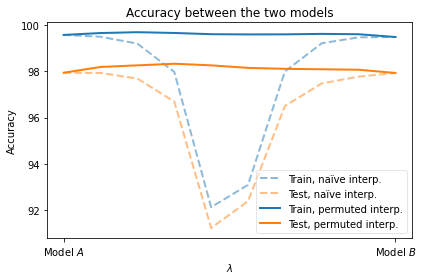

In [112]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [166]:
# load in model state_dicts
model_file_path = 'mode_connectivity/model_files/' # use this path in colab

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [167]:
train_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size": 128, 'num_workers': 0, 'pin_memory': False}

train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs, eval_only=True,
)

In [172]:
a = state_dict_to_torch_tensor(weights_a)
b = state_dict_to_torch_tensor(weights_pb)

print('checking sq euclidean distance', ((a - b)**2).sum())

checking sq euclidean distance tensor(1248.0438, device='cuda:0')


### Optimise for geodesic

In [175]:
from super import SuperModel
from mode_connectivity.geodesic_opt import optimise_for_geodesic

N = 10

super_model = SuperModel(MLP, N, weights_a, weights_pb).to(device)

a = state_dict_to_torch_tensor(super_model.models[0].state_dict())
b = state_dict_to_torch_tensor(super_model.models[-1].state_dict())

print('checking sq euclidean distance', ((a - b)**2).sum())

path_lengths, sq_euc_dists  = optimise_for_geodesic(
         super_model,
         train_loader,
         lr = 1e-1,
         verbose=1,
         num_epochs=30,)

a = state_dict_to_torch_tensor(super_model.models[0].state_dict())
b = state_dict_to_torch_tensor(super_model.models[-1].state_dict())

print('checking sq euclidean distance', ((a - b)**2).sum())

checking sq euclidean distance tensor(1248.0438, device='cuda:0')
Optimising geodesic ...
epoch 0 | path length 0.0002954492053343554 | sq euc dist 138.6814470433477
epoch 1 | path length 0.0002288685566690935 | sq euc dist 138.69410648630625
epoch 2 | path length 0.0001906892682902121 | sq euc dist 138.70653757882948
epoch 3 | path length 0.00016527062699624986 | sq euc dist 138.71810316886985
epoch 4 | path length 0.00014687776147009665 | sq euc dist 138.72874840449677
epoch 5 | path length 0.00013282271755449347 | sq euc dist 138.73855776810527
epoch 6 | path length 0.00012166331523702038 | sq euc dist 138.74762890130472
epoch 7 | path length 0.00011254632147689831 | sq euc dist 138.7560556773692
epoch 8 | path length 0.00010492883026822369 | sq euc dist 138.76392230205812
epoch 9 | path length 9.845030145835504e-05 | sq euc dist 138.7712993369682
epoch 10 | path length 9.285931222094592e-05 | sq euc dist 138.77824740808217
epoch 11 | path length 8.79750923008124e-05 | sq euc dist 1

Text(0, 0.5, 'path action via (squared) euclid dist')

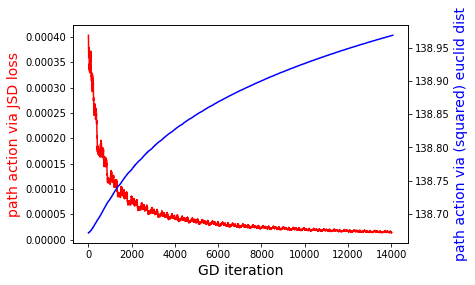

In [176]:
def rolling_mean(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

fig, ax = plt.subplots()

# CURRENTLY SET TO DO ROLLING MEAN
rolling_mean_length = rolling_mean(path_lengths, 50)

loss_type = 'JSD loss'

ax.plot(rolling_mean_length, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euc_dists, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

In [177]:
from geodesic_opt import evaluate_geodesic

# path_lengths are per step, acc is per model
train_path_length, train_acc = evaluate_geodesic(super_model, train_loader, verbose=0)
test_path_length, test_acc = evaluate_geodesic(super_model, test_loader, verbose=0)

Calculating path length and acc over geodesic:
Calculating path length and acc over geodesic:


In [178]:
np.set_printoptions(precision=3, linewidth=150)
print('train', train_path_length)
print('test', test_path_length)

train [5.902e-04 6.018e-04 5.352e-04 3.740e-04 2.667e-04 3.400e-04 4.854e-04 1.815e-03 1.573e-05]
test [6.692e-04 6.308e-04 5.572e-04 4.085e-04 3.116e-04 3.757e-04 5.098e-04 1.838e-03 6.928e-05]
